#### HELPERS & PREPARED

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    
    image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image.to(device)


def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image


def img_show(content, style):

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
  # content and style ims side-by-side
  ax1.imshow(im_convert(content))
  ax2.imshow(im_convert(style))

def load_vgg():
    vgg = models.vgg19(pretrained=True).features
    for param in vgg.parameters():
        param.requires_grad_(False)

    print(vgg)
    vgg.to(device)
    return vgg


def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    # We'll take sample representations from different steps in the image
    layers = {'0': 'conv1_1',
              '5': 'conv2_1', 
              '10': 'conv3_1', 
              '19': 'conv4_1',
              '21': 'conv4_2',  ## We'll take one at the very end as our content representation
              '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

def get_fts(content, style, vgg):
    """
    Returns: content_fts, style_fts, target
    """
    return get_features(content, vgg), get_features(style, vgg), content.clone().requires_grad_(True).to(device)



def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.orVGg/wiki/Gramian_matrix
    """
    batch_size, d, h, w = tensor.size()
    
    # Reshape into 2D tensor h, w by depth - we'll call this function for each item in a batch so no need to incl size
    matrix1 = tensor.view(d, h*w)
    
    # Multiplying the matrix by its transpose; wjhich is like a similarity metric ( the dot product ) This will reinforce similar things, i.e. the style
    gram = torch.mm(matrix1, matrix1.t())
    
    return gram


def calc_loss(target_fts, content_fts, style_fts, cont_w=0.01, style_w=1e10):

    cont_loss = torch.mean((target_fts['conv4_2'] - content_fts['conv4_2'])**2)

    style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}


    # Initialize to 0
    style_loss = 0

    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_fts[layer]
        _, d, h, w = target_feature.shape
        
        ## TODO: Calculate the target gram matrix
        target_gram = gram_matrix(target_feature)
        
        ## TODO:  get the "style" style representation
        style_gram = gram_matrix(style_fts[layer])

        ## TODO: Calculate the style loss for one layer, weighted appropriately
        layer_style_loss = torch.mean((target_gram - style_gram)**2) * style_weights[layer]
        
        # add to the style loss & normalize by the dimensions (ergo get the loss per pixel)
        style_loss += layer_style_loss / (d * h * w)


    total_loss = cont_loss * cont_w + style_loss * style_w

    return total_loss

  
def update(total_loss, i, optimizer):

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if i % 400 == 0:
        print('Total loss: ', total_loss.item())



In [ ]:
!wget https://techcrunch.com/wp-content/uploads/2014/12/matrix.jpg
# Upload FL1
# Upload PKU Garden

--2021-01-31 18:32:21--  https://techcrunch.com/wp-content/uploads/2014/12/matrix.jpg
Resolving techcrunch.com (techcrunch.com)... 152.195.50.33
Connecting to techcrunch.com (techcrunch.com)|152.195.50.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1468406 (1.4M) [image/jpeg]
Saving to: ‘matrix.jpg’

matrix.jpg          100%[===================>]   1.40M  --.-KB/s    in 0.04s   

2021-01-31 18:32:21 (35.3 MB/s) - ‘matrix.jpg’ saved [1468406/1468406]



In [ ]:
content = load_image("PKUlight.jpg")
style = load_image("./matrix.jpg")

vgg = load_vgg()

content_fts = get_features(content, vgg)
style_fts = get_features(style, vgg)

target = content.clone().requires_grad_(True).to(device)

cont_w = 0.05
style_w = 1e10

optimizer = optim.Adam([target], lr=0.003)

for i in range(1, 2000):

    target_fts = get_features(target, vgg)

    loss = calc_loss(target_fts, content_fts, style_fts, cont_w, style_w)
    
    update(loss, i, optimizer)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

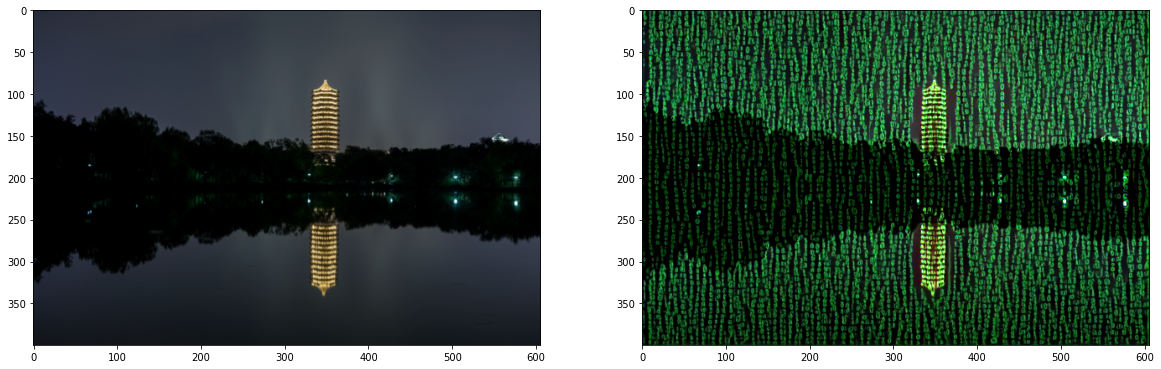

In [ ]:
img_show(content, target)

#### Code to write & explain

##### Lets first check the images; Style & Content

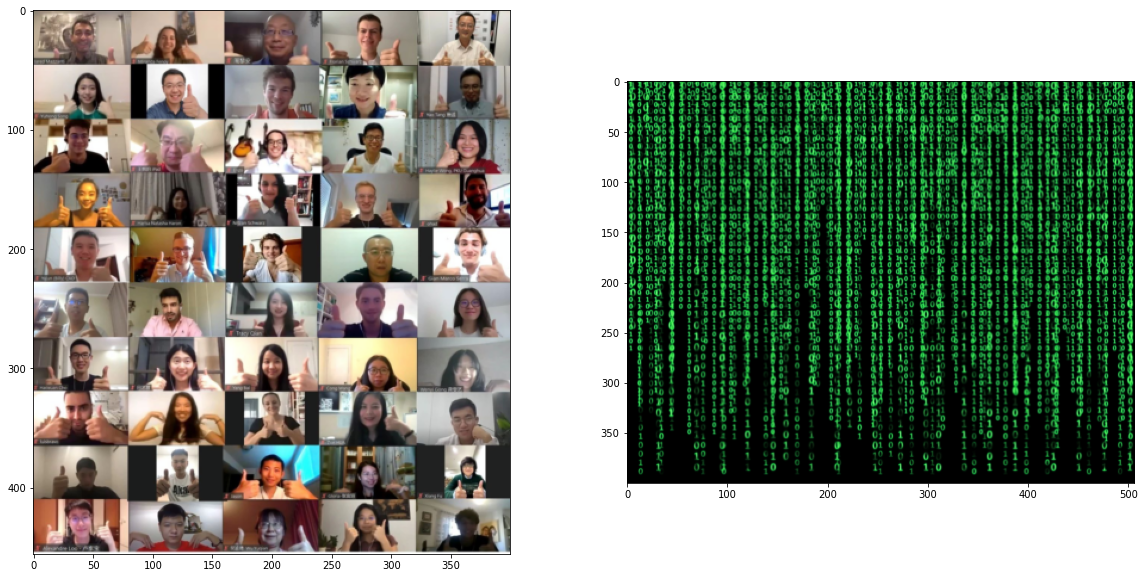

In [ ]:
content = load_image("FL_PKU.jpg")
style = load_image("./matrix.jpg") 

img_show(content, style)

##### To save us some time here, we'll download a public model from the ImageNet competition

In [ ]:
vgg = load_vgg()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPo

##### Next we want to use the knowledge of this model to get a represenation of our images -- i.e. even though the model is trained on completely different images it has learnt to represent images

In [ ]:
content_fts = get_features(content, vgg)
style_fts = get_features(style, vgg)

target = content.clone().requires_grad_(True).to(device)

##### Finally we need to train

In [ ]:
cont_w = 0.05
style_w = 1e10

optimizer = optim.Adam([target], lr=0.003)

for i in range(1, 1600):

    target_fts = get_features(target, vgg)

    loss = calc_loss(target_fts, content_fts, style_fts, cont_w, style_w)
    
    update(loss, i, optimizer)

Total loss:  10413735411712.0
Total loss:  4254685462528.0
Total loss:  2564739301376.0
Total loss:  1803156193280.0


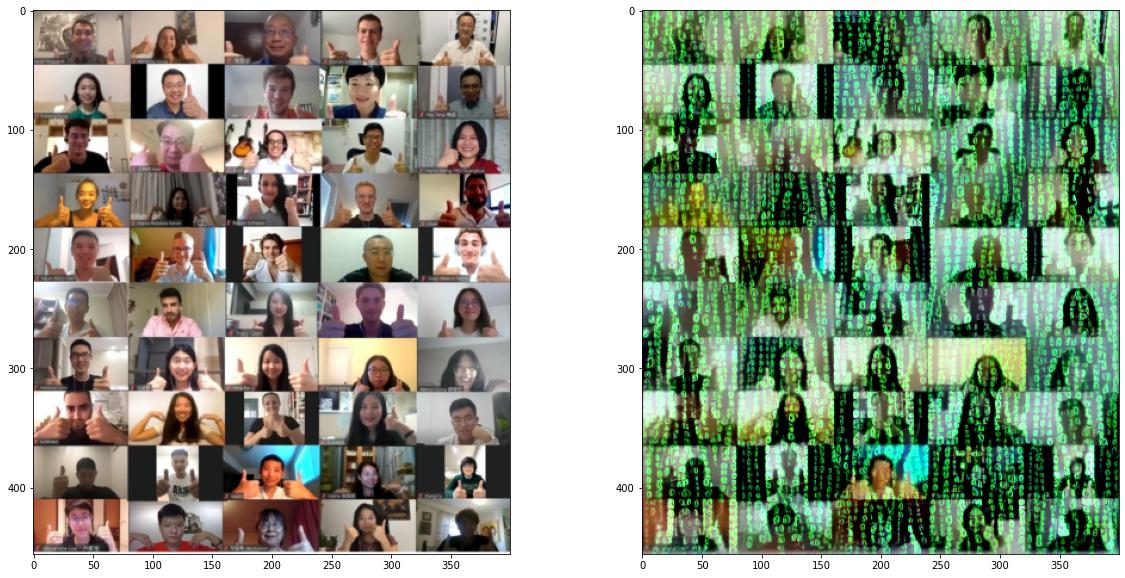

In [ ]:
img_show(content, target)